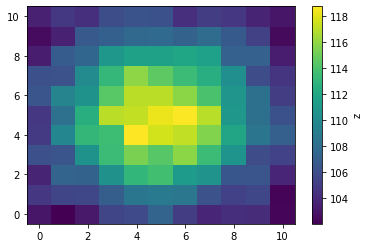

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, power
from numba import jit
import time
import lmfit
from lmfit import Minimizer, Parameters
from scipy.optimize import curve_fit


def Gauss2D(x, y, A, sigma, bg, x0, y0):
    return bg + A*exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2)))

def residuals(p,x,y,z):
    A = p["A"].value
    sigma = p["sigma"].value
    bg = p["bg"].value
    x0 = p["x0"].value
    y0 = p["y0"].value
    return Gauss2D(x,y,A,sigma,bg,x0,y0)-z

def Jacobian(p,x,y,z):
    A = p["A"].value
    sigma = p["sigma"].value
    bg = p["bg"].value
    x0 = p["x0"].value
    y0 = p["y0"].value
    e = exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2)))
    aes =  A*e*power(sigma,-2)
    return np.array([e, A*e*power(sigma,-3)*(power(x-x0,2)+power(y-y0,2)), np.ones(len(x)),aes*(x-x0), aes*(y-y0)])

def Jacobian_fix(p,x,y,z):
    A = p["A"].value
    sigma = p["sigma"].value
    bg = p["bg"].value
    x0 = p["x0"].value
    y0 = p["y0"].value
#     aes =  A*e*power(sigma,-2)
    return np.array([exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2))), np.ones(len(x))])


params = Parameters()
params.add('A', value=1)
params.add('sigma', value=3.0)
params.add('bg', value=100)
params.add('x0', value=5)
params.add('y0', value=5)
params["sigma"].vary = False
params["x0"].vary = False
params["y0"].vary = False

X, Y = np.meshgrid(np.linspace(0, 10, 11),
                   np.linspace(0, 10, 11))
Z = lmfit.lineshapes.gaussian2d(X,Y,amplitude=1000, centerx=5, centery=5, sigmax=3, sigmay=3)
Z+= 3*np.random.rand(*Z.shape)+100
fig, ax = plt.subplots()
art = ax.pcolor(X, Y, Z, shading='auto')
plt.colorbar(art, ax=ax, label='z')
plt.show()

X = X.ravel()
Y = Y.ravel()
Z = Z.ravel()

--- 2.3417325019836426 seconds ---


In [39]:
start_time = time.time()
min2 = Minimizer(residuals, params, fcn_args=(X,Y), fcn_kws={'z': Z})
# out2 = min2.leastsq(Dfun=Jacobian, col_deriv=1)
for i in range(1000): out2 = min2.leastsq(Dfun=Jacobian_fix, col_deriv=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.6293489933013916 seconds ---


In [36]:
# model = lmfit.models.ExpressionModel('bg+amplitude*exp(-((x-xc)**2+(y-yc)**2)/sigma**2)', independent_vars=['x','y'])
# params = model.make_params(bg = 100, xc = 5, yc = 5, sigma = 3, amplitude = 1)
# # params['bg'].min = 0
# params['xc'].vary = False
# params['yc'].vary = False
# params['sigma'].vary = False
# start_time = time.time()
# for i in range(1000): result = model.fit(Z, x=Y, y=X, params=params, verbose=False, calc_covar=False, method = 'trust-constr')
# print("--- %s seconds ---" % (time.time() - start_time))



--- 56.95009899139404 seconds ---


# SciPy implementation test

In [65]:
@jit
def _gaussian(M, A, sigma, bg, x0, y0):
    x, y = M
    return bg + A*exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2)))

@jit
def _jacobian(M, A, sigma, bg, x0, y0):
    x, y = M
    e = exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2)))
    aes =  A*e*power(sigma,-2)
    return np.transpose(np.array([e, A*e*power(sigma,-3)*(power(x-x0,2)+power(y-y0,2)), np.ones(len(x)),aes*(x-x0), aes*(y-y0)]))

xdata = np.vstack((X, Y))
p0 = [10,2.0,100,2,2]
popt = curve_fit(_gaussian, xdata, Z, p0, jac = _jacobian)



C:\Users\Anton\AppData\Local\Temp\ipykernel_3536\2471879813.py:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_jacobian" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(list(array(float64, 1d, C))<iv=None>)
 
There are 4 candidate implementations:
      - Of which 4 did not match due to:
      Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 129.
        With argument(s): '(list(array(float64, 1d, C))<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: array(float64, 1d, C) not allowed in a homogeneous sequence
  raised from C:\Users\Anton\anaconda3\envs\Spyder4\lib\site-packages\numba\core\typing\npydecl.py:488

During: resolving callee type: Function(<built-in function array>)
During: typing of call at C:\Users\Anton\AppData\Local\Temp\ipykern

In [92]:
sigma = 3.0
x0 = y0 = 5
def _jacobian_fix(M, A, bg):
    x, y = M
    return np.transpose(np.array([exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2))), np.ones(len(x))]))
def _gaussian_fix(M, A, bg):
    x, y = M
    return bg + A*exp(-0.5*power(sigma,-2)*(power(x-x0,2) + power(y-y0,2)))
                        
p0 = [10,50]                        
start_time = time.time()
bnds = ([0,0], [np.inf, np.inf])

for i in range(1000): popt = curve_fit(_gaussian_fix, xdata, Z, p0, jac = _jacobian_fix)
print("--- %s seconds ---" % (time.time() - start_time))

print(popt)

sigma = 1.0
x0 = y0 = 8
popt = curve_fit(_gaussian_fix, xdata, Z, p0, jac = _jacobian_fix)
print(popt)


--- 0.41092658042907715 seconds ---
(array([ 17.36960331, 101.6171623 ]), array([[ 0.10477937, -0.04276395],
       [-0.04276395,  0.02405143]]))
(array([ -1.30078686, 108.77320603]), array([[ 7.11548891, -0.36611976],
       [-0.36611976,  0.18475601]]))


In [89]:
print(popt[0])

[ -1.30078686 108.77320603]
